Emupy 1D Example
====
Duncan Rocha
6/30/17

In this example we use emupy to tackle a very simple toy problem. We have two underlying functions of $x$, $f$ and $g$, from which we make noisy data. The objective is to use emupy to set up a prediction function for the noisy data that accurately describes the underlying functions.

In [1]:
# Import modules
%matplotlib inline
import numpy as np
import emupy as emu
import sklearn.gaussian_process as gp
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import copy
import astropy.stats as astats

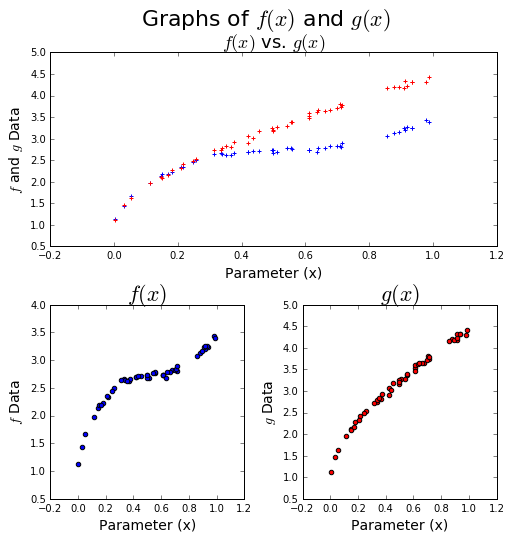

In [2]:
# Format of setting up data:
# Choose how many points between 0 and 1
n = 100

# Create linspace array
all_x = np.random.uniform(0,1,n)

# Specify functions
# defaults:  
# f(x) = sqrt(x) + sin(x)/4
# g(x) = 
f = lambda x: np.sqrt(6*x) + 1 + np.sin(x*np.pi*2)/4 + np.random.normal(0,.04,n)
g = lambda x: np.sqrt(6*x) + x + 1 + np.random.normal(0,.04,n)

# Create data array
fx = f(all_x)
gx = g(all_x)
all_data = np.array([fx,gx]).T

# Choose half of it to train the gaussian, half of it for cross validation at the end
indices = np.arange(0,n,1)
rand = np.random.choice(indices,n//2,replace=False)
select = np.zeros(n,dtype='bool')
select[rand] = True
x_train = all_x[select]
data = all_data[select]
x_cv = all_x[~select]
data_cv = all_data[~select]

# Pick out f(x) and g(x) for graphing
fx = data.T[0]
gx = data.T[1]

# Create matplotlib figure to display data
fig1 = plt.figure(figsize=(8,8))
fig1.suptitle('Graphs of $f(x)$ and $g(x)$',fontsize=22)
fig1.subplots_adjust(wspace=0.3,hspace=0.3)

# Plot f and g data together
ax1 = fig1.add_subplot(211)
ax1.scatter(x_train,fx,marker='+')
ax1.scatter(x_train,gx,c='r',marker='+')
ax1.set_title('$f(x)$ vs. $g(x)$',fontsize='18')
ax1.set_xlabel('Parameter (x)',fontsize=14)
ax1.set_ylabel('$f$ and $g$ Data',fontsize=14)

# Plot only f(x)
ax2 = fig1.add_subplot(223)
ax2.scatter(x_train,fx)
ax2.set_title('$f(x)$',fontsize=22)
ax2.set_xlabel('Parameter (x)',fontsize=14)
ax2.set_ylabel('$f$ Data',fontsize=14)

# Plot only g(x)
axe3 = fig1.add_subplot(224)
axe3.scatter(x_train,gx,c='r')
axe3.set_title('$g(x)$',fontsize=22)
axe3.set_xlabel('Parameter (x)',fontsize=14)
axe3.set_ylabel('$g$ Data',fontsize=14)

In [3]:
E = emu.Emu()

# Specify number of samples in training data
E.N_samples = len(x_train)

# Specify number of model parameters
E.N_params = 1

# Specify number of data elements
E.N_data = 2

# Specify usage of pca or not (automatically sets N_modes too). Try toggling this and watching the fit
# change, but keep in mind the runtime changes too with larger data pools.
E.use_pca = False
if E.use_pca == True: E.N_modes = 1
else: E.N_modes = 2

# Choose regression model for interpolation functions
E.reg_meth = 'gaussian'

# Choose to log normalize the data before regression
E.lognorm = False

# Whiten the covariance matrix of the data before performing KLT
E.cov_whiten = False

In [4]:
# Set fidutial arrays. These are just arrays of the average (or median) of every input parameter and
# data element. Used for centering the data.
#E.fid_grid = np.array([np.median(x_train)])
#E.fid_data = np.array(map(np.median,data.T))
E.fid_grid = np.array([np.median(x_train)])
E.fid_data = np.array(map(np.median, data.T))

In [5]:
# Since we have only have one input parameter, 'x', numpy won't allow transposing the array from a flat
# (,n) vector into a column vector (n,). The trick around this is to define x_data as a matrix of
# x_array, and transpose that into a column matrix. With any parameter space with more than one
# element, you can define x_data as a column array of all coordinates entries.
x_column = np.matrix(x_train).T

In [6]:
## This cell is the general procedure of using emupy. Whereas the procedure is mostly invariant to the data,
## the kwargs are what is customizable. One can also specify exactly how the gaussian process regression will work
## with the gp_kwargs dictionary.
# Call E.sphere (cholesky decomposition) on the input column array 
E.sphere(x_column,fid_grid = E.fid_grid, save_chol=True)

# Call klt on the data array to find eigenvectors (used as pca bases)
E.klt(data,fid_data=E.fid_data,normalize=True)

## Setup Gaussian Process kwargs
# Setup a squared exponential kernel with diagonal noise hyperparameter
kernel = gp.kernels.RBF(length_scale=np.ones(E.N_params)) + gp.kernels.WhiteKernel(noise_level=1e-6)

# How many times to restart MLE search of hyperparameters
n_restarts_optimizer = 10

# Which optimizer to use
optimizer='fmin_l_bfgs_b'

# pack into a dictionary
gp_kwargs = {'kernel':kernel, 'n_restarts_optimizer':n_restarts_optimizer, 'optimizer':optimizer}
E.gp_kwargs = gp_kwargs

## Initialize E.train, which sets up gaussian processes for future predictions.
E.train(data,x_column)

# See how long it took!

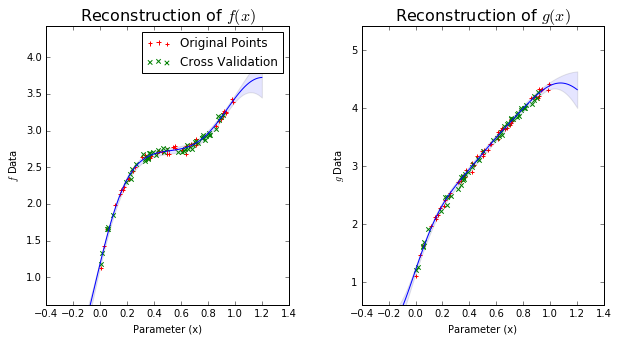

In [7]:
# Create new prediction coordinate array
nnew = 100
pred_coords = np.linspace(-0.2,1.2,nnew)
pred_input = np.asmatrix(pred_coords).T

# Run through E.predict
E.predict(pred_input)

# Extract predictions (E.recon) and predicted error (E.recon_err) and make graphable arrays
pred_output = E.recon
pred_err= E.recon_err
err_high = (pred_output+pred_err).T
err_low = (pred_output-pred_err).T

fig2 = plt.figure(figsize=(10,5))
fig2.subplots_adjust(wspace=0.3)

# Plot 1: prediction of f(x) against the original f(x) data (red) and cross validation (green)
ax3 = fig2.add_subplot(121)
ax3.plot(pred_coords,pred_output.T[0])
ax3.fill_between(pred_coords,err_low[0],err_high[0],alpha=0.1)
orig = ax3.scatter(x_train,fx,color='r',marker='+')
cv = ax3.scatter(x_cv,data_cv.T[0],color = 'g', marker='x')
ax3.set_title('Reconstruction of $f(x)$',fontsize=16)
ax3.set_xlabel('Parameter (x)')
ax3.set_ylabel('$f$ Data')
ax3.set_ylim(np.min(fx)-0.5,np.max(fx)+1)

# Plot 2: prediction of g(x) against the original g(x) data (red) and cross validation data (green)
ax4 = fig2.add_subplot(122)
ax4.plot(pred_coords,(pred_output).T[1])
ax4.scatter(x_train,gx,color = 'r', marker='+')
ax4.fill_between(pred_coords,err_low[1],err_high[1],alpha=0.1)
ax4.scatter(x_cv,data_cv.T[1],color = 'g', marker='x')
ax4.set_title('Reconstruction of $g(x)$', fontsize=16)
ax4.set_xlabel('Parameter (x)')
ax4.set_ylabel('$g$ Data')
ax4.set_ylim(np.min(gx)-0.5,np.max(gx)+1)

ax3.legend([orig, cv], ["Original Points", "Cross Validation"])

In [8]:
# Set up new emupy object for which we will create a polynomial fit
poly = copy.deepcopy(E)
poly.reg_meth = 'poly'
poly.train(data,x_column)
poly.predict(pred_input)

# Extract predictions (E.recon) and predicted error (E.recon_err) and make graphable arrays
poly_output = poly.recon
poly_err= poly.recon_err
poly_err_high = (poly_output+poly_err).T
poly_err_low = (poly_output-poly_err).T

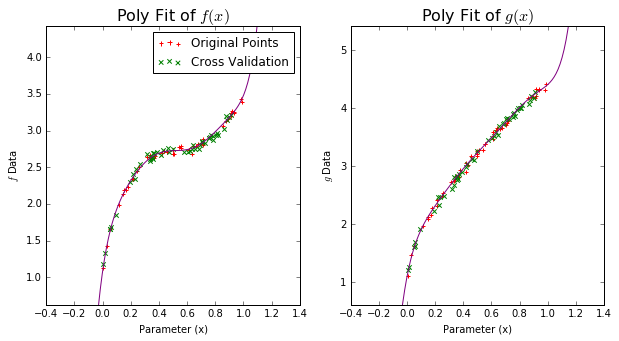

In [9]:
fig3 = plt.figure(figsize=(10,5))

# Plot 1: prediction of f(x) against the original f(x) data (red) and cross validation (green)
ax5 = fig3.add_subplot(121)
ax5.plot(pred_coords,poly_output.T[0],color='purple')
orig = ax5.scatter(x_train,fx,color='r',marker='+')
cv = ax5.scatter(x_cv,data_cv.T[0],color = 'g', marker='x')
ax5.set_title('Poly Fit of $f(x)$',fontsize=16)
ax5.set_xlabel('Parameter (x)')
ax5.set_ylabel('$f$ Data')
ax5.set_ylim(np.min(fx)-0.5,np.max(fx)+1)

# Plot 2: prediction of g(x) against the original g(x) data (red) and cross validation data (green)
ax6 = fig3.add_subplot(122)
ax6.plot(pred_coords,poly_output.T[1],c='purple')
ax6.scatter(x_train,gx,color = 'r', marker='+')
ax6.scatter(x_cv,data_cv.T[1],color = 'g', marker='x')
ax6.set_title('Poly Fit of $g(x)$', fontsize=16)
ax6.set_xlabel('Parameter (x)')
ax6.set_ylabel('$g$ Data')
ax6.set_ylim(np.min(gx)-0.5,np.max(gx)+1)

ax5.legend([orig, cv], ["Original Points", "Cross Validation"])

(-0.15, 0.15)

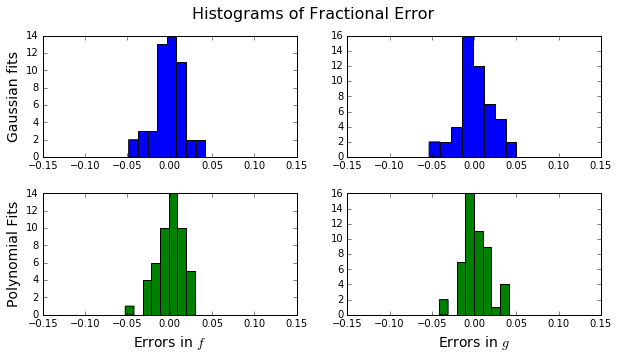

In [10]:
# Now for some statistical cross validation. First, we will use cross_validate to generate
# predictions for g and f for every x value in x_cv. Remember that we have to turn the array x_cv
# into a matrix x_cvm in order to pass it through emupy.

# Create histogram axes
fig4 = plt.figure(figsize=(10,5))
fig4.suptitle('Histograms of Fractional Error',fontsize='16')
fig4.subplots_adjust(wspace=0.2,hspace=0.3)
hist1 = fig4.add_subplot(221)
hist2 = fig4.add_subplot(222)
hist3 = fig4.add_subplot(223)
hist4 = fig4.add_subplot(224)

# Get data from E.cross_validate
x_cvm = np.asmatrix(x_cv).T
E.cross_validate(x_cvm,data_cv)
poly.cross_validate(x_cvm,data_cv)


# Take the fractional error from the cross validation output in E.recon_cv
frac_err = (E.recon_cv - data_cv) / data_cv
poly_frac_err = (poly.recon_cv - data_cv) / data_cv

# Plot the data into histograms
hist1.hist(frac_err.T[0],bins=8)
hist1.set_ylabel('Gaussian fits',fontsize=14)
hist1.set_xlim(-0.15,0.15)

hist2.hist(frac_err.T[1],bins=8)
hist2.set_xlim(-0.15,0.15)

hist3.hist(poly_frac_err.T[0],bins=8,color='g')
hist3.set_ylabel('Polynomial Fits',fontsize=14)
hist3.set_xlabel('Errors in $f$',fontsize=14)
hist3.set_xlim(-0.15,0.15)

hist4.hist(poly_frac_err.T[1],bins=8,color='g')
hist4.set_xlabel('Errors in $g$',fontsize=14)
hist4.set_xlim(-0.15,0.15)

# For the plots below, the top two are the fractional error of the gaussian cross validation of f and g respectively, 
# and the bottom two the fractional errors from the polynomial cross validation